In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from griddedoutput_plotting import *
from loaddatastructs import *

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
GriddedOutput.archive_path = '/data/keeling/a/sf20/e/wrf-partmc-gridded-output'
GriddedOutput.gridsize = 100

GriddedOutput.addScenario(scenario_name='uniform-basecase', slurm_id=4599545)
GriddedOutput.addScenario(scenario_name='point-source-1x1', slurm_id=4599634)

In [3]:
# NOTE: USER SELECT SCENARIO
scenario = 'uniform-basecase'
#scenario = 'point-source-1x1'

z_idx = 0 # 0 indexing
t_idx = 1 # 1 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

File does not exist, processing data


In [122]:
GriddedOutput.scenario_slurm_map.keys()

dict_keys(['uniform-basecase', 'point-source-1x1'])

In [120]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [123]:
# NOTE: USER SELECT SCENARIO
#scenario = 'uniform-basecase'
scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

for scenario in GriddedOutput.scenario_slurm_map:
    for t_idx in np.arange(1, 38):
        for z_idx in np.arange(0, 100, 10):
            print(scenario, t_idx, z_idx)
            GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

uniform-basecase 1 0
File does not exist, processing data
uniform-basecase 1 10
File does not exist, processing data
uniform-basecase 1 20
File does not exist, processing data
uniform-basecase 1 30
File does not exist, processing data
uniform-basecase 1 40
Loading file
uniform-basecase 1 50
File does not exist, processing data
uniform-basecase 1 60
File does not exist, processing data
uniform-basecase 1 70
File does not exist, processing data
uniform-basecase 1 80
File does not exist, processing data
uniform-basecase 1 90
File does not exist, processing data
uniform-basecase 2 0
File does not exist, processing data
uniform-basecase 2 10
File does not exist, processing data
uniform-basecase 2 20
File does not exist, processing data
uniform-basecase 2 30
File does not exist, processing data
uniform-basecase 2 40
Loading file
uniform-basecase 2 50
File does not exist, processing data
uniform-basecase 2 60
File does not exist, processing data
uniform-basecase 2 70
File does not exist, proc

Plot the mean number distribution across the vertical layer

In [49]:
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                          particle_numconc_arr=GriddedOutput.gridded_data[scenario]['aero_numconc'],
                                                          n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


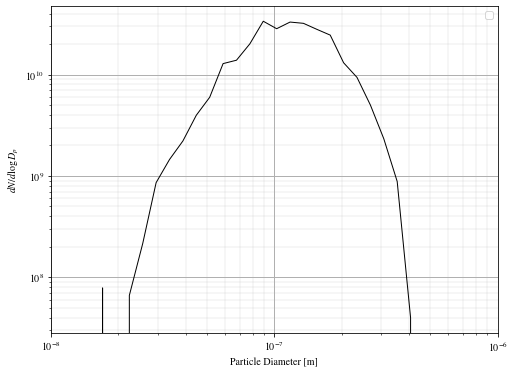

In [6]:
plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line',
                xlims=(1e-8, 1e-6) 
               #ylims=(1e6, 1e11)
               )

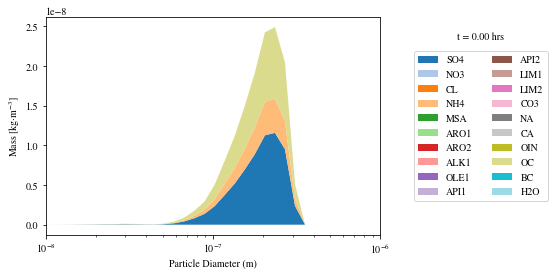

In [4]:
crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                                             GriddedOutput.gridded_data[scenario]['aero_masses'], 
                                                                             GriddedOutput.gridded_data[scenario]['aero_numconc'], 
                                                                             n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', xlims=(1e-8, 1e-6),
                      scenario=scenario, t_idx=t_idx, z_idx=z_idx, savefig=False
                      )

In [ ]:
def plotSpeciatedMassFrac(binned_species_mass_arr, **kwargs):
    if binned_species_mass_arr.shape[1] == GriddedOutput.n_bins:
        binned_species_mass_arr = binned_species_mass_arr[:, :-1]

    total_mass_per_bin = (binned_species_mass_arr[:, :]#/bin_logwidth # moved division by logwidth to calculation of mass distrib
                          ).sum(axis=0)
    frac_total = np.zeros((GriddedOutput.n_bins-1,))
    fig, ax = plt.subplots(1, 1)
    # Plot the total speciated mass distribution
    for i, species in enumerate(GriddedOutput.aero_species):
        species_mass_dist = binned_species_mass_arr[i, :]#/bin_logwidth # moved division by logwidth to calculation of mass distrib
        species_frac = species_mass_dist/total_mass_per_bin
        frac_total += species_frac
        if i == 0:
            y_lower = 0
            y_lower = np.array((GriddedOutput.n_bins-1)*[y_lower])
        else:
            y_lower = frac_total - species_frac
        ax.fill_between(x=GriddedOutput.bin_geocenter, y1=y_lower, y2=frac_total, label=species)

    plt.xlim(GriddedOutput.bin_edges[0], GriddedOutput.bin_edges[-1])
    plt.ylim(0, 1)
    plt.xscale('log')
    plt.ylabel('Mass Fraction')
    plt.xlabel('Particle Diameter (m)')
    if kwargs.get('xlims'):
        plt.xlim(kwargs.get('xlims'))
    plt.legend(loc='center', bbox_to_anchor=(1.3, .5), ncol=2)
    if kwargs.get('t_idx'):
        t = kwargs.get('t_idx')
        history_dt = GriddedOutput.historydelta_m/60 # hours
        time =  ((t-1)*history_dt)
        plt.text(1.3, .9, f't = {time:3.2f} hrs', transform=ax.transAxes, horizontalalignment='center')

Note that the IC for aerosols (50% ammonium nitrate and 50% POA) is given in mass fractions but the aero_ic netcdf files passed to WRF-PartMC expect *volume fractions*. See the following for conversion between the two https://en.wikipedia.org/wiki/Volume_fraction. 

This explains why my mass fractions are slightly different than whats dictated in Riemer et al. 2009 (I passed mass fractions to the aero_ic which assumes volume fractions).

In [20]:
species_masses = crosssec_binned_mean_species_mass_optimized[:, 40] # species masses from a random bin in the middle of the mass dist
species_density = GriddedOutput.gridded_data[scenario]['species_density']
species_volume = species_masses/species_density
volume_fraction = species_volume / species_volume.sum(axis=0) # referred to as 'phi' on wikipedia

In [25]:
volume_fraction.data

array([0.3636, 0.    , 0.    , 0.1364, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.5   , 0.    , 0.    ])

In [21]:
mixture_density = (species_density*volume_fraction).sum(axis=0)
mass_fraction = (species_density*volume_fraction)/mixture_density

In [23]:
mass_fraction.data

array([0.46467292, 0.        , 0.        , 0.17431625, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.36101083, 0.        , 0.        ])

Compute volume fraction via mass fraction via

In [32]:
vol_frac_derived = (mass_fraction/species_density)/((mass_fraction/species_density).sum())

In [33]:
vol_frac_derived.data

array([0.3636, 0.    , 0.    , 0.1364, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.5   , 0.    , 0.    ])

/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:115: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


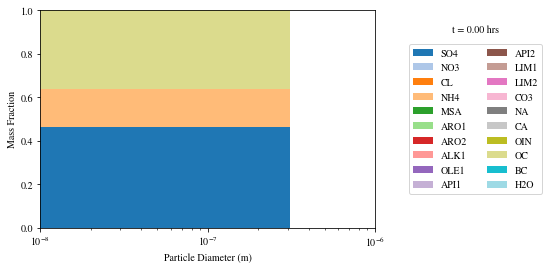

In [8]:
plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 1e-6), 
                      scenario=scenario, t_idx=t_idx, z_idx=z_idx, savefig=False
                      )

In [19]:
crosssec_binned_mean_species_mass_optimized[:,30]

array([3.66748292e-10, 0.00000000e+00, 0.00000000e+00, 1.37581042e-10,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.84931827e-10, 0.00000000e+00, 0.00000000e+00])

In [22]:
slurmid = GriddedOutput.scenario_slurm_map[scenario]
output_path = GriddedOutput.archive_path
output_subdir = os.path.join(output_path, f'slurm-{slurmid}')

if os.path.isfile(f'./crosssec_data/crosssec_{scenario}_t{t_idx}_z{z_idx}.nc'):
    crosssec_data = nc.Dataset(f'./crosssec_data/crosssec_{scenario}_t{t_idx}_z{z_idx}.nc', 'r', format='NETCDF4')

Plot the number distribution for each hour on the same figure (requires loading in NetCDF datasets)

Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


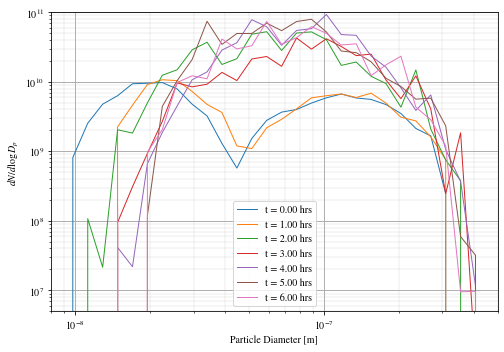

In [5]:
#scenario = 'uniform-basecase'
scenario = 'point-source-1x1'

z_idx = 1 # 0 indexing
t_idx = 37 # 1 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
times = np.arange(1, GriddedOutput.n_times+1,6)

for t, c in zip(times, colors):

    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t)
    
    crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                              particle_numconc_arr=GriddedOutput.gridded_data[scenario]['aero_numconc'],
                                                              n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

    
    ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color=c, t_idx=t,
                        #yscale='linear'
                        #ylims=(1e6, 1e11)
                        xlims=(8e-9, 5e-7), ylims=(5e6, 1e11)
                        )


Make speciated mass distribution and mass fraction plots for the basecase

In [ ]:
scenario = 'uniform-basecase'
#scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

#colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
#fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
time_interval = 1
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
for t in times:
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t)
    crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                                                 GriddedOutput.gridded_data[scenario]['aero_masses'], 
                                                                                 GriddedOutput.gridded_data[scenario]['aero_numconc'], 
                                                                                 n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

    plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', 
                      xlims=(1e-8, 4e-6), scenario=scenario, t_idx=t, z_idx=z_idx, savefig=False
                      )
    #plt.close()
    plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 7e-7), 
                        scenario=scenario, t_idx=t, z_idx=z_idx, savefig=False
                      )
    #plt.close()

Loading file
Loading file
Loading file
Loading file


/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:186: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


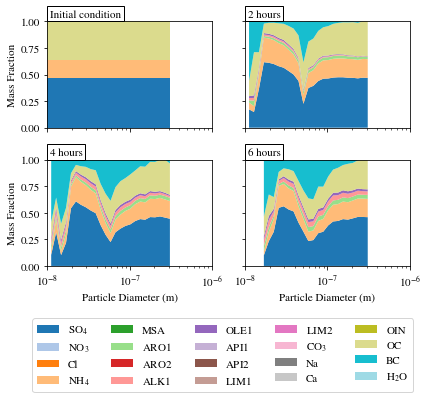

In [3]:
scenario = 'uniform-basecase'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

time_interval = 12 # output is 10 mins, so 2 hr between each subplot
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
plotFourPanelMassFrac(scenario, times, xstart, xend, ystart, yend, z_idx, yscale='linear', 
                      subplot_title_fontsize=11, 
                      xlims=(1e-8, 1e-6),savefig=True)

Loading file
Loading file
Loading file
Loading file


/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:186: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


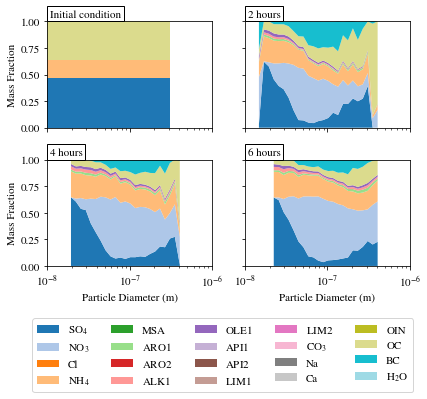

In [4]:
scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

time_interval = 12 # output is 10 mins, so 2 hr between each subplot
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
plotFourPanelMassFrac(scenario, times, xstart, xend, ystart, yend, z_idx, yscale='linear',
                      subplot_title_fontsize=11, 
                      xlims=(1e-8, 1e-6),savefig=True)

Print variable names, dimensions, and descriptions

In [19]:
printGriddedOutputInfo(data)

process                      dimensions: ()           description: the process number (starting from 1) that output this data file  -  
total_processes              dimensions: ()           description: total number of processes  -  
time                         dimensions: ()           description: time elapsed since simulation start  -  
timestep                     dimensions: ()           description: current timestep size  -  
timestep_index               dimensions: ()           description: an integer that is 1 on the first timestep, 2 on the second timestep, etc.  -  
gas_species                  dimensions: (77,)        description: dummy dimension variable (no useful value) - read species names as comma-separated values from the 'names' attribute  -  
gas_mosaic_index             dimensions: (77,)        description: MOSAIC indices of gas species  -  
aero_species                 dimensions: (20,)        description: dummy dimension variable (no useful value) - read species n

Code for 2d (kappa vs. diameter) kappa distributions

In [ ]:
# NOTE: USER SELECT SCENARIO
scenarios = ['uniform-basecase', 'point-source-1x1']

#z_idx = 40 # 0 indexing
#t_idx = 18

for t_idx in np.arange(1, 38, 6): # each hour (note using 1-indexing here)
    for z_idx in np.arange(0, 91, 10): # every 10th vertical level

        # use a width of 10, horizontally average across the 10x10 grid cells
        xstart, xend = 45, 55 # 1 indexing
        ystart, yend = 45, 55 # 1 indexing

        plotScenarios2DKappaDists(scenarios, xstart, xend, ystart, yend, z_idx, t_idx)

        plt.close()
        

Loading file
Loading file
Loading file
Loading file


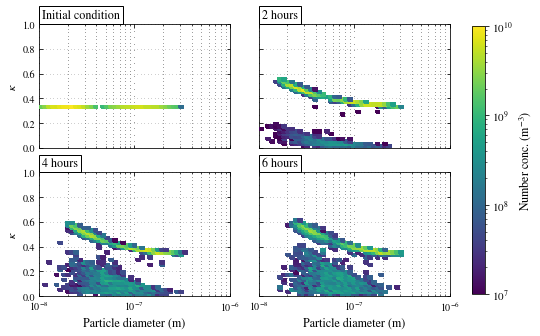

In [5]:
# NOTE: USER SELECT SCENARIO
scenario = 'uniform-basecase'
#scenario = 'point-source-1x1'
z_idx = 40 # 0 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

general_labels = {'uniform-basecase': 'Uniform base case', 
                    'point-source-1x1': 'Scenario 3'}

plotScenario2DKappaDist4Panel(scenario, xstart, xend, ystart, yend, z_idx)

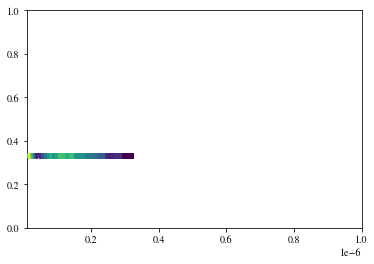

In [35]:

# 1-d arrays with per-particle attributes
kappa = GriddedOutput.gridded_data[scenario]['aero_kappa']
diams = GriddedOutput.gridded_data[scenario]['aero_diams']
numconc = GriddedOutput.gridded_data[scenario]['aero_numconc']
n_cells = GriddedOutput.gridded_data[scenario]['n_total_cells']

diam_bins = np.logspace(-8, -6, 50)
#diam_bins = GriddedOutput.bin_edges
kappa_bins = np.linspace(0, 1, 51)
diam_logwidth = (np.log10(diam_bins[1:]) - np.log10(diam_bins[0:-1]))[0]
kappa_width = (kappa_bins[1:] - kappa_bins[0:-1])[0]
fig,ax = plt.subplots(1,1)
hist, xedges, yedges, cs = ax.hist2d(diams, kappa, bins=[diam_bins, kappa_bins], weights=numconc/(diam_logwidth*n_cells), 
                                    density=False, cmin=1,edgecolor='face', linewidth=.1, zorder=10)

In [42]:
kappa_bins[16]

0.32

In [41]:
hist[:, 16]

array([2.26448110e+09, 2.75294410e+09, 4.48446110e+09, 5.63911667e+09,
       6.97116085e+09, 8.39166623e+09, 9.59068455e+09, 8.83592358e+09,
       9.41342731e+09, 7.72579806e+09, 6.83777617e+09, 6.17156263e+09,
       4.79528314e+09, 2.66409198e+09, 1.33191934e+09,            nan,
       1.28777876e+09, 1.36823547e+09, 2.81700685e+09, 2.73649880e+09,
       4.14495124e+09, 5.27171389e+09, 6.07651837e+09, 5.19124532e+09,
       5.91563593e+09, 6.88136471e+09, 6.76068828e+09, 6.07660860e+09,
       6.64002073e+09, 4.94975201e+09, 5.03025406e+09, 4.02417749e+09,
       3.74252980e+09, 3.05841736e+09, 1.12674511e+09, 1.44871102e+09,
       2.41454394e+08,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan])

Loading file
Loading file
Loading file
Loading file


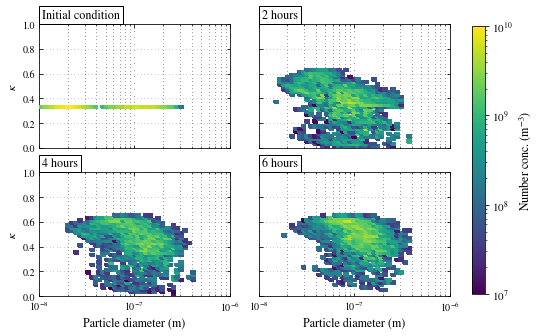

In [6]:
# NOTE: USER SELECT SCENARIO
scenario = 'point-source-1x1'
z_idx = 40 # 0 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

general_labels = {'uniform-basecase': 'Uniform base case', 
                    'point-source-1x1': 'Scenario 3'}

plotScenario2DKappaDist4Panel(scenario, xstart, xend, ystart, yend, z_idx)

Code for 1-d kappa distributions, dividing the distribution into nucleation, aitken, accumulation modes

In [4]:
# NOTE: USER SELECT SCENARIO
scenarios = ['uniform-basecase', 'point-source-1x1']

z_idx = 40 # 0 indexing
#t_idx = 19

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

for t_idx in np.arange(1, 38, 6): # each hour (note using 1-indexing here)
    plotScenarios1DKappaDists(scenarios, xstart, xend, ystart, yend, z_idx, t_idx)
    


Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


In [3]:
scenarios = ['uniform-basecase', 'point-source-1x1']

z_idx = 40 # 0 indexing
#t_idx = 19

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

t_idx = 37

plotScenarios1DKappaDists(scenarios, xstart, xend, ystart, yend, z_idx, t_idx)

Loading file
Loading file


In [14]:
nucleation_mode.shape

(49, 50)

In [13]:
 np.nansum(nucleation_mode, axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.34413461e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [53]:
def KappaDist(scenario):
    kappa = GriddedOutput.gridded_data[scenario]['aero_kappa']
    particle_multipicity = GriddedOutput.gridded_data[scenario]['aero_numconc']

    nbins = 90
    kappa_bins = np.linspace(0, 1, nbins+1)
    kappa_width = kappa_bins[1] - kappa_bins[0]

    digitized = np.digitize(kappa, kappa_bins) 
    bin_conc = np.zeros(nbins)

    for bin_idx in np.arange(nbins):
        bin_conc[bin_idx] = (particle_multipicity[(digitized-1)==bin_idx].sum())/kappa_width
    bin_conc = bin_conc/GriddedOutput.gridded_data[scenario]['n_total_cells']

    return kappa_bins, bin_conc

Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


Text(0, 0.5, '$dN/d\\kappa$')

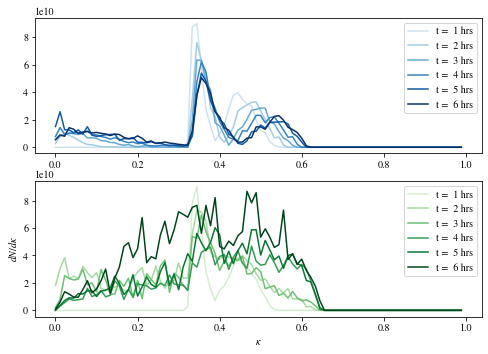

In [105]:
z_idx = 20 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

times = np.arange(7, 38, 6)

basecase_colors = plt.get_cmap('Blues')(np.linspace(0.2, 1, times.size))
pointsource_colors = plt.get_cmap('Greens')(np.linspace(0.2, 1, times.size))

fig, ax = plt.subplots(2, 1, figsize=(8, 5.5))


for i, t_idx in enumerate(times):

    scenario = 'uniform-basecase'
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
    bins, bin_conc = KappaDist(scenario)
    history_dt = GriddedOutput.historydelta_m/60 # hours
    time =  ((t_idx-1)*history_dt)
    label = f't = {time:2.0f} hrs'
    ax[0].plot(bins[:-1], bin_conc, label=label, c=basecase_colors[i])

    scenario = 'point-source-1x1'
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
    bins, bin_conc = KappaDist(scenario)

    ax[1].plot(bins[:-1], bin_conc,c=pointsource_colors[i], label=label)



ax[0].legend()
ax[1].legend()
#plt.yscale('log')
#plt.ylim(0, 1.4e11)
plt.xlabel('$\kappa$')
plt.ylabel('$dN/d\kappa$')


Loading file
Loading file


Text(0.5, 1.0, 't =  6 hrs')

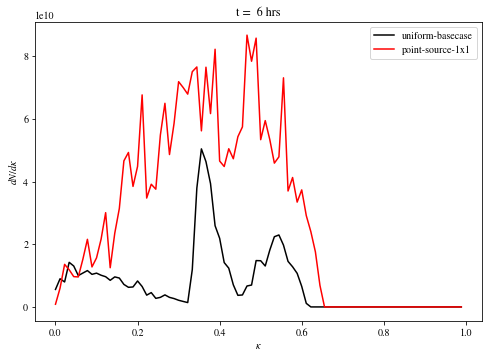

In [118]:


z_idx = 20 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing
t_idx=37

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))

scenario = 'uniform-basecase'
GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
bins, bin_conc = KappaDist(scenario)

ax.plot(bins[:-1], bin_conc, label=scenario, c='k')

scenario = 'point-source-1x1'
GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
bins, bin_conc = KappaDist(scenario)

ax.plot(bins[:-1], bin_conc,c='r', label=scenario)



ax.legend()
#plt.yscale('log')
#plt.ylim(0, 1.4e11)
plt.xlabel('$\kappa$')
plt.ylabel('$dN/d\kappa$')
history_dt = GriddedOutput.historydelta_m/60 # hours
time =  ((t_idx-1)*history_dt)
label = f't = {time:2.0f} hrs'
plt.title(label)